# Hunting Exoplanets In Space - Data Processing

We will process the data before deploying a prediction model so that it can learn the properties of the different stars through the training dataset.

Now, there is no right approach to the data processing method. It is an iterative process. So based on some research and hit and trials. we will perform the following data processing:

1. Data Normalisation

2. Fast Fourier Transformation

3. Oversampling

Finally, we will check if the Random Forest Classifier model is still providing the expected results. If not, then we will deploy XGBoost Classifier.

---


1. Train dataset

   https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/whitehat-ds-datasets/kepler-exoplanets-dataset/exoTrain.csv

2. Test dataset

   https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/whitehat-ds-datasets/kepler-exoplanets-dataset/exoTest.csv

In [121]:
# Load both the training and test datasets.
import numpy as np
import pandas as pd

exo_train_df = pd.read_csv('exoTrain.csv')
exo_test_df = pd.read_csv('exoTest.csv')

In [122]:
# The shapes of the 'exo_train_df' and 'exo_test_df' DataFrames.
print(exo_train_df.shape)
exo_test_df.shape

(5087, 3198)


(570, 3198)

In [123]:
exo_test_df[:5]

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,...,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,2,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,...,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,...,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,2,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,...,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,2,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,...,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84


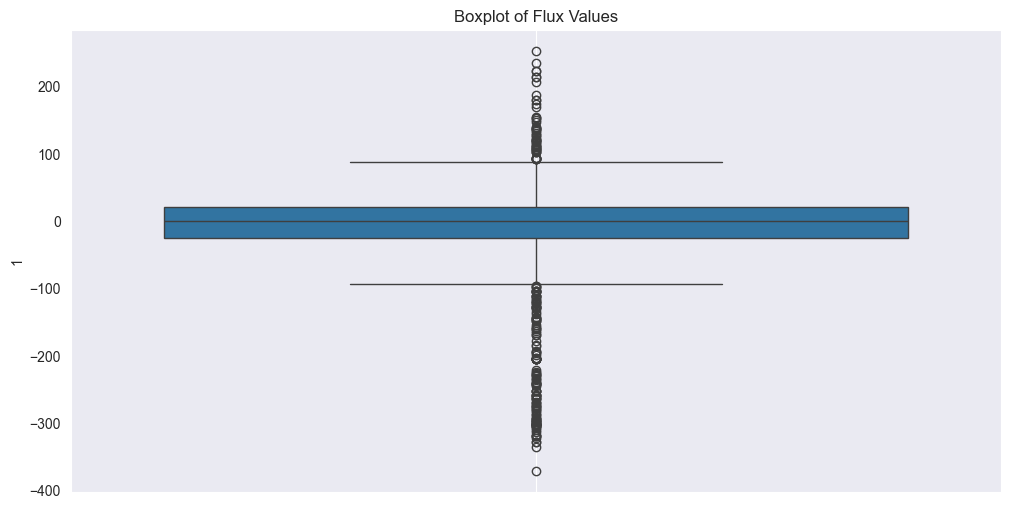

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=exo_train_df.iloc[1, 1:])  # Excluding the LABEL column
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.title("Boxplot of Flux Values")
plt.grid()
plt.show()


In [125]:
import numpy as np

Q1 = exo_train_df.iloc[:, 1:].quantile(0.25, axis = 0)  # First quartile (Q1)
Q3 = exo_train_df.iloc[:, 1:].quantile(0.75, axis = 0)  # Third quartile (Q3)
IQR = Q3 - Q1

print(Q1)
print("++++"*90)
print(Q3)
outliers = ((exo_train_df.iloc[:, 1:] < (Q1 - 1.5 * IQR)) | (exo_train_df.iloc[:, 1:] > (Q3 + 1.5 * IQR))).sum()

print("Number of outliers per Flux column:\n", outliers)


FLUX.1      -42.340
FLUX.2      -39.520
FLUX.3      -38.505
FLUX.4      -35.050
FLUX.5      -31.955
              ...  
FLUX.3193   -24.405
FLUX.3194   -26.760
FLUX.3195   -24.065
FLUX.3196   -21.135
FLUX.3197   -19.820
Name: 0.25, Length: 3197, dtype: float64
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
FLUX.1       48.255
FLUX.2       44.285
FLUX.3       42.325
FLUX.4       39.765
FLUX.5       39.750
              ...  
FLUX.3193    30.855
FLUX.3194    18.175
FLUX.3195    18.770
FLUX.3196    19.465
FLUX.3197    20.280
Name: 0.75, Length: 3197, dtype: float64
Number of outliers per Flux column:
 FLUX.1       1178
FLUX.2       1204
FLUX.3       1204
FLUX.4       1223
FLUX.5  

There are outliers present in the data we should consider the zsocre and the mean normilization techiniques

---

#### 1: Data Normalisation


**What is data normalisation?**

Data normalisation is a process of standardising data. It brings every single data-point on a uniform scale. If you look at both the `exo_train_df` and `exo_test_df` DataFrames, they contain highly varying `FLUX` values.

You can get the data summary using the `describe()` function to look at the variation of the data.

**Syntax:** `dataframe_name.describe()`

In [126]:
exo_train_df.describe()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
count,5087.000000,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,...,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5087.000000,5087.000000,5087.000000,5087.000000
mean,1.007273,1.445054e+02,1.285778e+02,1.471348e+02,1.561512e+02,1.561477e+02,1.469646e+02,1.168380e+02,1.144983e+02,1.228639e+02,...,3.485578e+02,4.956476e+02,6.711211e+02,7.468790e+02,6.937372e+02,6.553031e+02,-494.784966,-544.594264,-440.239100,-300.536399
std,0.084982,2.150669e+04,2.179717e+04,2.191309e+04,2.223366e+04,2.308448e+04,2.410567e+04,2.414109e+04,2.290691e+04,2.102681e+04,...,2.864786e+04,3.551876e+04,4.349963e+04,4.981375e+04,5.087103e+04,5.339979e+04,17844.469520,17722.339334,16273.406292,14459.795577
min,1.000000,-2.278563e+05,-3.154408e+05,-2.840018e+05,-2.340069e+05,-4.231956e+05,-5.975521e+05,-6.724046e+05,-5.790136e+05,-3.973882e+05,...,-3.240480e+05,-3.045540e+05,-2.933140e+05,-2.838420e+05,-3.288214e+05,-5.028894e+05,-775322.000000,-732006.000000,-700992.000000,-643170.000000
25%,1.000000,-4.234000e+01,-3.952000e+01,-3.850500e+01,-3.505000e+01,-3.195500e+01,-3.338000e+01,-2.813000e+01,-2.784000e+01,-2.683500e+01,...,-1.760000e+01,-1.948500e+01,-1.757000e+01,-2.076000e+01,-2.226000e+01,-2.440500e+01,-26.760000,-24.065000,-21.135000,-19.820000
50%,1.000000,-7.100000e-01,-8.900000e-01,-7.400000e-01,-4.000000e-01,-6.100000e-01,-1.030000e+00,-8.700000e-01,-6.600000e-01,-5.600000e-01,...,2.600000e+00,2.680000e+00,3.050000e+00,3.590000e+00,3.230000e+00,3.500000e+00,-0.680000,0.360000,0.900000,1.430000
75%,1.000000,4.825500e+01,4.428500e+01,4.232500e+01,3.976500e+01,3.975000e+01,3.514000e+01,3.406000e+01,3.170000e+01,3.045500e+01,...,2.211000e+01,2.235000e+01,2.639500e+01,2.909000e+01,2.780000e+01,3.085500e+01,18.175000,18.770000,19.465000,20.280000
max,2.000000,1.439240e+06,1.453319e+06,1.468429e+06,1.495750e+06,1.510937e+06,1.508152e+06,1.465743e+06,1.416827e+06,1.342888e+06,...,1.779338e+06,2.379227e+06,2.992070e+06,3.434973e+06,3.481220e+06,3.616292e+06,288607.500000,215972.000000,207590.000000,211302.000000


As you can see, the values in the `FLUX.1` column range between `-227,856.3` (minimum `FLUX.1` value) and `1,439,240` (maximum `FLUX.1` value).

**Note:** `-2.278563e+05` is equivalent to $-2.278563\times10^5$ and `1.439240e+06` equivalent to $1.439240\times10^6$

In the `FLUX.1` column, the difference in the maximum and minimum values, i.e.,

$$1,439,240 - (-227,856.3) = 1,667,096.3$$


is huge because of the $$[10^5]$$ and $$[10^6]$$ scales.

Similarly, the data in all the other `FLUX` columns also vary a lot because they lie on a huge scale. The big figures are less readable. For e.g., `122` (one hundred twenty two) is more readable than `1,439,240` (one million, four hundred thirty nine thousand, two hundred forty).

The data normalisation process lowers the scale and brings all the data-points on the same scale.


##### **Normalization Techniques**

Normalization techniques are methods used to **scale numerical data** so that it falls within a specific range, improving the performance of machine learning models. They help **avoid bias** in models where features have different magnitudes.  

---

#### **1️⃣ Min-Max Scaling (Rescaling)**
##### ✅ **Formula:**  
$$[
X' = \frac{X - X_{min}}{X_{max} - X_{min}}
]$$
✅ **Scales values to a fixed range (usually [0, 1] or [-1, 1]).**  
✅ **Best for:** When data has a known range and no extreme outliers.  

**🔸 Example:**  
If `X = 30`, `X_min = 10`, and `X_max = 50`:  
$$[
X' = \frac{30 - 10}{50 - 10} = \frac{20}{40} = 0.5
]$$

---

#### **2️⃣ Z-Score Normalization (Standardization)**
##### ✅ **Formula:**  
$$[
X' = \frac{X - \mu}{\sigma}
]$$
✅ **Centers data around 0 with a standard deviation of 1.**  
✅ **Best for:** When data follows a normal distribution.  

**🔸 Example:**  
If `X = 70`, `μ = 50`, and `σ = 10`:  
$$[
X' = \frac{70 - 50}{10} = 2
]$$

---

#### **3️⃣ Mean Normalization**
##### ✅ **Formula:**  
$$[
X' = \frac{X - \mu}{X_{max} - X_{min}}
]$$
✅ **Centers the data around zero (range between -1 and 1).**  
✅ **Best for:** Cases where we need to remove bias and scale data.  

---

#### **4️⃣ Log Transformation**
##### ✅ **Formula:**  
$$[
X' = \log(X + 1)
]$$
✅ **Reduces skewness in data with a large range or exponential growth.**  
✅ **Best for:** Data with heavy-tailed distributions (e.g., income data).  

---

#### **5️⃣ Robust Scaling (Median-Based)**
##### ✅ **Formula:**  
$$[
X' = \frac{X - \text{median}}{\text{IQR}}
]$$
✅ **Uses median and Interquartile Range (IQR) instead of mean/std.**  
✅ **Best for:** Data with extreme outliers.  

---

#### In Short
- **Min-Max Scaling** → When feature ranges are known and **no outliers** exist.  
- **Z-Score Normalization** → When data is normally distributed.  
- **Mean Normalization** → When you need zero-centered data with a limited range.  
- **Log Transformation** → When data is highly skewed.  
- **Robust Scaling** → When **outliers** are present.  
---

In [127]:
def normz(ser):
    return (ser - ser.mean()) / ser.std()

In [128]:
def norm(ser):
  return ((ser - ser.mean())/(ser.max() - ser.min()))

In [129]:
norm(pd.Series([5, 192, 20019, 12, 209]))

0   -0.203977
1   -0.194634
2    0.796023
3   -0.203627
4   -0.193784
dtype: float64

Now, let's test the `mean_normalise()` function on the $[5, 192, 20019, 12, 209]$ series. If we get the desired output, then it means the function is working correctly.

In [130]:
# Student Action: Test the 'mean_normalise()' function on the '[5, 192, 20019, 12, 209]' series.
norm(pd.Series([5, 192, 20019, 12, 209]))

0   -0.203977
1   -0.194634
2    0.796023
3   -0.203627
4   -0.193784
dtype: float64

Now, let's apply the `mean_normalise()` function on the `exo_train_df` DataFrame to normalise only the `FLUX` values.

Using the `iloc[]` function, we will first exclude the `LABEL` column from the DataFrame and then will apply the `mean_normalise()` function on the `exo_train_df` DataFrame using the `apply()` function.

The `apply()` function takes two inputs.

- The first input is the function that needs to be applied which in this case is `mean_normalise()` function.

- The second input is the `axis` value which signifies whether the function in the first input needs to be applied vertically or horizontally.

**Syntax:** `dataframe.apply(function_name, axis)`

**Note:** Whenever you apply a function, say `function_name()` on a DataFrame using the `apply()` function, remove the brackets from the name of the function (i.e., `function_name`) to be applied. That's why the syntax is `dataframe.apply(function_name, axis)`

A DataFrame has two axes (axes is plural of axis).

- The first axis is the vertical axis. It is represented as `axis = 0`

- The second axis is the horizontal axis. It is represented as `axis = 1`

The DataFrame axes define whether an operation needs to be applied row-wise or column-wise. Refer to the image shown below.

<img src='https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/lesson-16/dataframe-axes.png' width=600>

1. If `axis = 0`, then it means the function needs to be applied **vertically**. In other words, the function will be applied on all the rows but only **one column at a time.** So, on the `exo_train_df` DataFrame, if the `mean_normalise()` function is applied **vertically**, then it will be applied in the following order:

    - `exo_train_df.iloc[:, 0]`, i.e., all the rows and the `FLUX.1` column at a time.
    
    - `exo_train_df.iloc[:, 1]`, i.e., all the rows and the `FLUX.2` column at a time.

    - `exo_train_df.iloc[:, 2]`, i.e., all the rows and the `FLUX.3` column at a time.

    ...

    - `exo_train_df.iloc[:, 3197]`, i.e., all the rows and the `FLUX.3197` column at a time.

2. If `axis = 1`, then it means the function needs to be applied **horizontally**. This means the function will be applied on all the columns but only **one row at a time.** So, on the `exo_train_df` DataFrame, if the `mean_normalise()` function is applied **horizontally**, then it will be applied in the following order:

    - `exo_train_df.iloc[0, :]`, i.e., the first row and all the columns at a time.
    
    - `exo_train_df.iloc[1, :]`, i.e., the second row and all the columns at a time.

    - `exo_train_df.iloc[2, :]`, i.e., the third row and all the columns at a time.

      ...

    - `exo_train_df.iloc[5086, :]`, i.e., the last row and all the columns at a time.

We will apply the `mean_normalise()` function **horizontally** on the `exo_train_df` DataFrame to normalise the `FLUX` values for a star at a time.


In [131]:

nom_train_df = exo_train_df.iloc[:,1:].apply(norm, axis = 1)
nom_train_df[:5]

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,0.053834,0.047391,0.006510,-0.023699,-0.031772,-0.086410,-0.093128,-0.068161,-0.057650,-0.109164,...,-0.056482,-0.071934,-0.071934,0.009738,0.024779,0.052993,0.018843,0.033024,-0.003127,-0.031759
1,-0.050411,-0.042317,-0.081922,-0.052351,-0.115212,-0.104794,-0.126816,-0.124861,-0.122681,-0.105708,...,0.006648,-0.039721,-0.039721,-0.027988,0.004116,0.013124,-0.006847,0.022260,0.037550,0.043849
2,0.243983,0.245509,0.235186,0.227365,0.208538,0.212981,0.212283,0.222467,0.199285,0.221536,...,-0.037161,0.002382,0.002382,-0.017715,-0.013523,-0.001456,-0.009299,-0.017259,-0.036384,-0.048782
3,0.518501,0.551177,0.480659,0.474051,0.504754,0.496863,0.511941,0.494687,0.496425,0.513506,...,0.016215,0.001435,0.001435,0.054324,0.038636,-0.012562,-0.006456,-0.019827,-0.019889,0.029163
4,-0.399904,-0.401872,-0.404199,-0.395473,-0.381734,-0.373293,-0.360070,-0.368986,-0.356861,-0.350022,...,-0.212262,-0.141752,-0.141752,-0.125499,-0.157156,-0.155246,-0.141038,-0.135528,-0.145458,-0.181590


In [132]:
nomz_train_df = exo_train_df.iloc[:,1:].apply(normz, axis = 1)
nomz_train_df[:5]

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,0.521974,0.459509,0.063126,-0.229790,-0.308059,-0.837834,-0.902975,-0.660890,-0.558979,-1.058455,...,-0.547656,-0.697473,-0.697473,0.094421,0.240257,0.513824,0.182707,0.320205,-0.030324,-0.307935
1,-0.524105,-0.439954,-0.851711,-0.544268,-1.197814,-1.089501,-1.318459,-1.298129,-1.275467,-1.098999,...,0.069120,-0.412959,-0.412959,-0.290981,0.042791,0.136440,-0.071188,0.231423,0.390394,0.455882
2,1.860570,1.872206,1.793484,1.733848,1.590274,1.624154,1.618833,1.696491,1.519711,1.689396,...,-0.283383,0.018167,0.018167,-0.135091,-0.103127,-0.011101,-0.070914,-0.131615,-0.277459,-0.372004
3,3.207775,3.409928,2.973657,2.932781,3.122729,3.073910,3.167189,3.060446,3.071198,3.176876,...,0.100317,0.008878,0.008878,0.336081,0.239025,-0.077717,-0.039941,-0.122661,-0.123049,0.180422
4,-2.684628,-2.697843,-2.713465,-2.654883,-2.562650,-2.505984,-2.417214,-2.477073,-2.395673,-2.349765,...,-1.424955,-0.951607,-0.951607,-0.842499,-1.055016,-1.042194,-0.946817,-0.909826,-0.976489,-1.219045


In [133]:
nomz_train_df.describe()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
count,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,...,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000
mean,-0.010874,-0.028059,-0.041027,-0.044515,-0.040765,-0.061644,-0.037994,-0.049267,-0.047667,-0.061416,...,0.107671,0.104291,0.124411,0.168694,0.149536,0.173239,-0.052449,-0.010476,0.000336,0.008921
std,2.428671,2.380164,2.309969,2.137069,2.029555,2.039795,1.947216,1.848420,1.799162,1.726986,...,1.027751,0.996673,1.017123,1.163696,1.422992,1.281263,1.138184,1.192210,0.988110,0.999232
min,-14.098908,-12.894473,-13.295502,-11.267925,-10.376598,-9.887198,-9.389682,-8.752038,-8.120397,-8.101943,...,-5.787132,-5.820574,-5.958839,-6.420422,-6.898586,-8.726331,-5.805539,-5.315994,-5.762964,-11.995048
25%,-1.088876,-1.090434,-1.025186,-1.005923,-0.936241,-0.944691,-0.861252,-0.833653,-0.810822,-0.792327,...,-0.484044,-0.506244,-0.480806,-0.516934,-0.557874,-0.563202,-0.660678,-0.606054,-0.566544,-0.557869
50%,-0.061501,-0.067201,-0.075346,-0.044243,-0.047259,-0.070154,-0.073127,-0.074535,-0.059994,-0.075801,...,0.093924,0.102345,0.104210,0.129073,0.128369,0.134043,-0.054801,-0.013356,0.011716,0.029762
75%,1.029981,0.954854,0.929865,0.874279,0.807175,0.760105,0.754187,0.725304,0.668163,0.671673,...,0.686606,0.709030,0.741926,0.872771,0.858316,0.928619,0.526028,0.550507,0.574632,0.593749
max,27.246384,40.647216,45.439675,19.943752,9.744080,28.678162,28.214068,16.802482,35.960982,17.928039,...,25.187532,12.167002,6.453945,13.062491,54.322281,10.294740,28.347336,46.555369,18.533870,6.725747


In [134]:
nom_train_df.describe()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
count,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,...,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000,5087.000000
mean,0.000685,-0.000596,-0.001566,-0.001202,-0.000740,-0.002470,-0.000730,-0.001281,-0.001421,-0.002037,...,0.005165,0.004794,0.006335,0.008774,0.006500,0.008134,-0.005690,-0.003288,-0.001603,-0.001082
std,0.168811,0.163252,0.158553,0.153144,0.147773,0.145188,0.140170,0.135593,0.130129,0.127598,...,0.093178,0.094372,0.096610,0.103292,0.105772,0.110695,0.096611,0.094191,0.091258,0.091374
min,-0.779681,-0.747867,-0.747912,-0.778677,-0.745649,-0.740931,-0.846553,-0.714771,-0.640588,-0.667493,...,-0.608219,-0.753987,-0.639173,-0.648696,-0.661599,-0.668388,-0.825602,-0.631304,-0.592546,-0.597935
25%,-0.063742,-0.063744,-0.062319,-0.057512,-0.052546,-0.054312,-0.049331,-0.046963,-0.045058,-0.045002,...,-0.024968,-0.026192,-0.025883,-0.026775,-0.030718,-0.031387,-0.037260,-0.032210,-0.030542,-0.029569
50%,-0.002517,-0.002839,-0.002772,-0.002135,-0.002052,-0.002845,-0.002978,-0.002874,-0.002454,-0.003042,...,0.004009,0.003962,0.004231,0.005519,0.005356,0.005589,-0.002089,-0.000566,0.000496,0.001265
75%,0.060475,0.057469,0.054974,0.052705,0.048321,0.044719,0.044202,0.041961,0.038599,0.038929,...,0.036174,0.037022,0.039469,0.046060,0.046883,0.051388,0.027713,0.028485,0.030228,0.031811
max,0.927562,0.909774,0.975016,0.892899,0.781205,0.913806,0.916485,0.819859,0.805654,0.865495,...,0.876997,0.629574,0.656747,0.643289,0.980652,0.648446,0.915423,0.958154,0.653278,0.570174


In [136]:
round(nom_train_df.iloc[1,1:].mean())

0

In [137]:
round(nom_train_df.iloc[:,1:].mean())

FLUX.2      -0.0
FLUX.3      -0.0
FLUX.4      -0.0
FLUX.5      -0.0
FLUX.6      -0.0
            ... 
FLUX.3193    0.0
FLUX.3194   -0.0
FLUX.3195   -0.0
FLUX.3196   -0.0
FLUX.3197   -0.0
Length: 3196, dtype: float64

You can see that, all the data-points are on the same scale after mean normalisation. Notice that we didn't normalise the `LABEL` data as we intended.

Now, let's insert the `LABEL` column to the `norm_train_df` DataFrame to get the full DataFrame with the normalised `FLUX` values.

We can obtain the `LABEL` column from the `exo_train_df` DataFrame using the `exo_train_df['LABEL']` method.

To insert a column in a DataFrame, use the `insert()` function. It takes three inputs.

- The first input should be the desired column index of the new column after its insertion.

- The second input should be the desired column name.

- The third input should be the values of the new column.

**Syntax:** `dataframe.insert(loc=column_index, column=column_name, value=some_pandas_series)`

In [138]:
nom_train_df.insert(loc = 0, column = 'LABEL', value=exo_train_df['LABEL'])
nom_train_df[:5]

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,0.053834,0.047391,0.006510,-0.023699,-0.031772,-0.086410,-0.093128,-0.068161,-0.057650,...,-0.056482,-0.071934,-0.071934,0.009738,0.024779,0.052993,0.018843,0.033024,-0.003127,-0.031759
1,2,-0.050411,-0.042317,-0.081922,-0.052351,-0.115212,-0.104794,-0.126816,-0.124861,-0.122681,...,0.006648,-0.039721,-0.039721,-0.027988,0.004116,0.013124,-0.006847,0.022260,0.037550,0.043849
2,2,0.243983,0.245509,0.235186,0.227365,0.208538,0.212981,0.212283,0.222467,0.199285,...,-0.037161,0.002382,0.002382,-0.017715,-0.013523,-0.001456,-0.009299,-0.017259,-0.036384,-0.048782
3,2,0.518501,0.551177,0.480659,0.474051,0.504754,0.496863,0.511941,0.494687,0.496425,...,0.016215,0.001435,0.001435,0.054324,0.038636,-0.012562,-0.006456,-0.019827,-0.019889,0.029163
4,2,-0.399904,-0.401872,-0.404199,-0.395473,-0.381734,-0.373293,-0.360070,-0.368986,-0.356861,...,-0.212262,-0.141752,-0.141752,-0.125499,-0.157156,-0.155246,-0.141038,-0.135528,-0.145458,-0.181590


In [139]:
nomz_train_df.insert(loc= 0,column = 'LABEL',value=exo_train_df['LABEL'])


-------------------------Star 1-------------------------



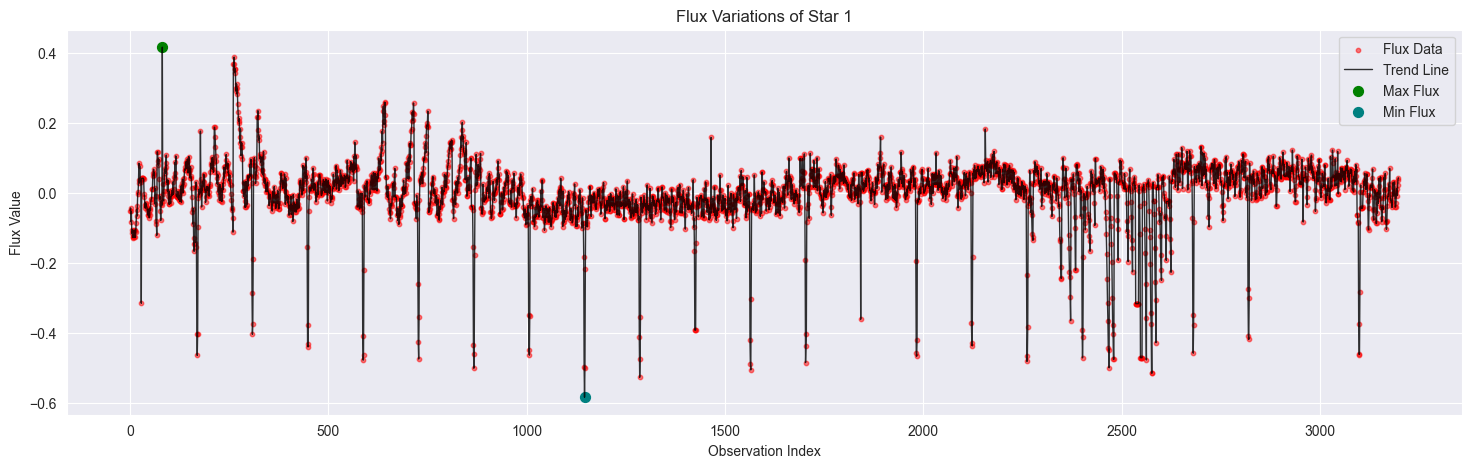


Star 1 - Max Flux: 0.4168356532779718, Min Flux: -0.5831643467220282, Label: 2.0

Star 1 Have Planets


-------------------------Star 2-------------------------



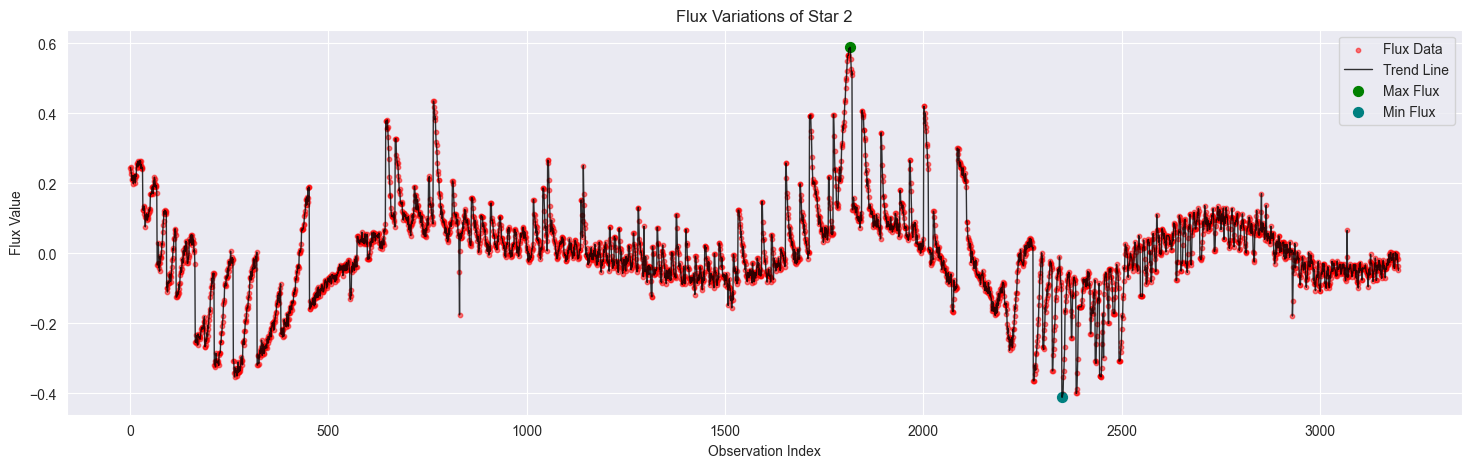


Star 2 - Max Flux: 0.5891497312710029, Min Flux: -0.41085026872899716, Label: 2.0

Star 2 Have Planets


-------------------------Star 3-------------------------



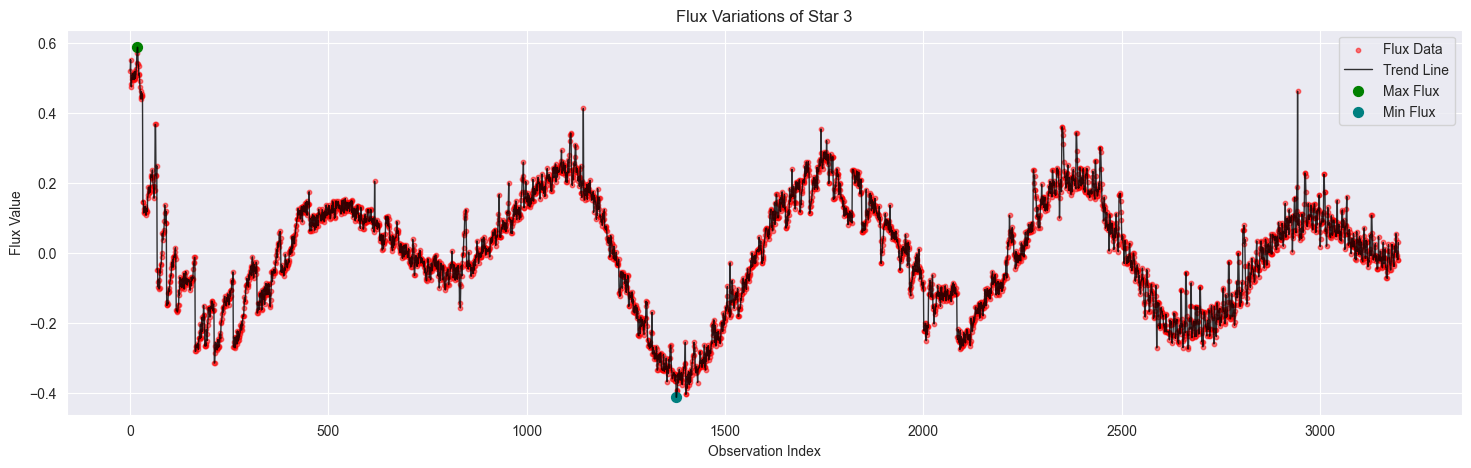


Star 3 - Max Flux: 0.5870308242143598, Min Flux: -0.4129691757856402, Label: 2.0

Star 3 Have Planets


-------------------------Star 5084-------------------------



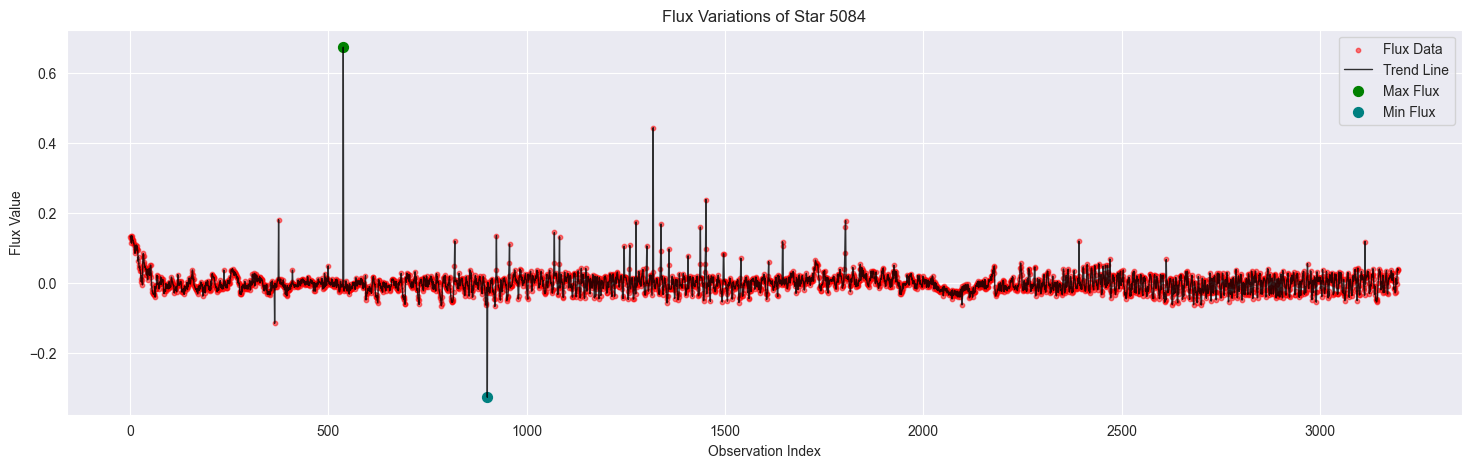


Star 5084 - Max Flux: 0.6740158717494656, Min Flux: -0.32598412825053436, Label: 1.0

Star 5084 Do not have Planets


-------------------------Star 5085-------------------------



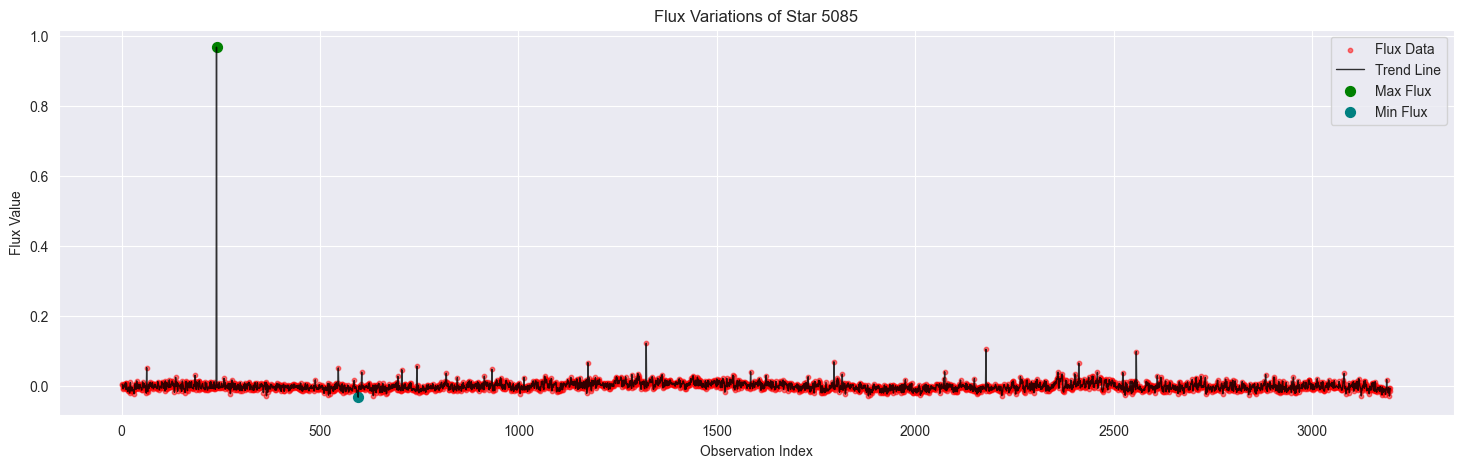


Star 5085 - Max Flux: 0.9682203877763054, Min Flux: -0.03177961222369477, Label: 1.0

Star 5085 Do not have Planets


-------------------------Star 5086-------------------------



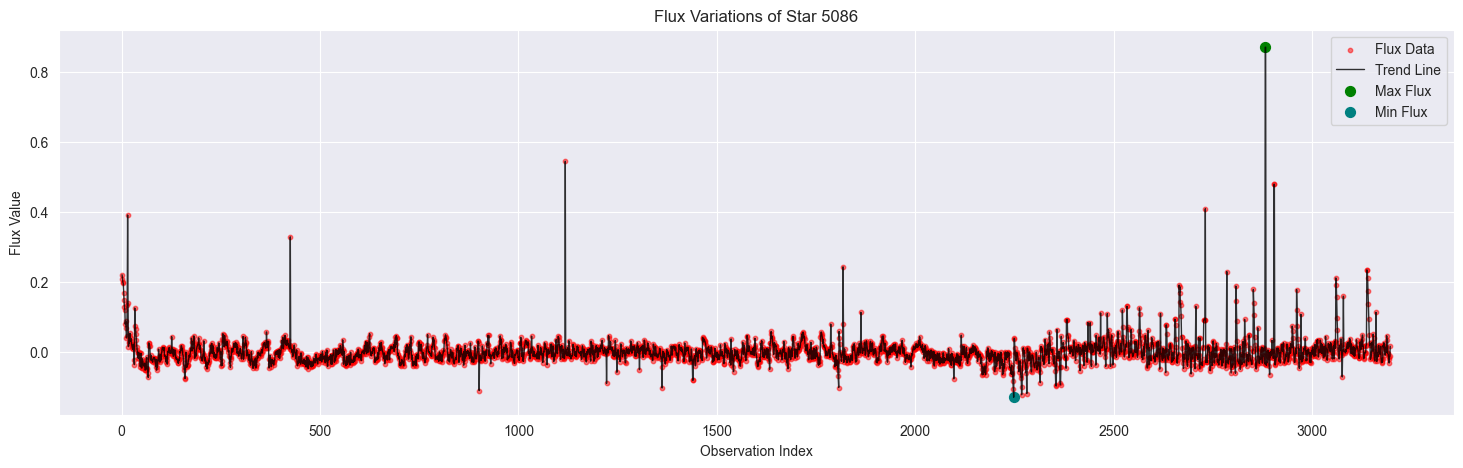


Star 5086 - Max Flux: 0.8700847460752216, Min Flux: -0.12991525392477854, Label: 1.0

Star 5086 Do not have Planets



In [140]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set Seaborn style for better visualization
sns.set_style("darkgrid")

# Define selected stars
stars = {
    "Star 1": nom_train_df.iloc[1, :],
    "Star 2": nom_train_df.iloc[2, :],
    "Star 3": nom_train_df.iloc[3, :],
    "Star 5084": nom_train_df.iloc[5084, :],
    "Star 5085": nom_train_df.iloc[5085, :],
    "Star 5086": nom_train_df.iloc[5086, :]
}

# Generate x-values
x_values = np.arange(1, len(stars["Star 1"]))

# Iterate through each star and generate individual plots
for star_name, flux_values in stars.items():
    y_values = flux_values[1:]
    max_flux = y_values.max()
    min_flux = y_values.min()
    acutal_label = flux_values.iloc[0]

    plt.figure(figsize=(18, 5), dpi=100)

    print(f"\n{"-"*25}{star_name}{"-"*25}\n")

    # Scatter plot and line plot overlay
    plt.scatter(x_values, y_values, alpha=0.5, label="Flux Data", color="red", s=10)
    plt.plot(x_values, y_values, color="black", linewidth=1, label="Trend Line",alpha = 0.8)

    # Highlight max and min points
    plt.scatter(x_values[y_values.argmax()], max_flux, color="green", marker="o", s=50, label="Max Flux")
    plt.scatter(x_values[y_values.argmin()], min_flux, color="teal", marker="o", s=50, label="Min Flux")

    # Labels and title
    plt.xlabel("Observation Index")
    plt.ylabel("Flux Value")
    plt.title(f"Flux Variations of {star_name}")
    plt.legend()

    # Show the plot for each star
    plt.show()

    # Print max and min values
    print(f"\n{star_name} - Max Flux: {max_flux}, Min Flux: {min_flux}, Label: {acutal_label}")
    print(f"\n{star_name} {"Have Planets" if acutal_label == 2 else "Do not have Planets"}\n")



-------------------------Star 1-------------------------



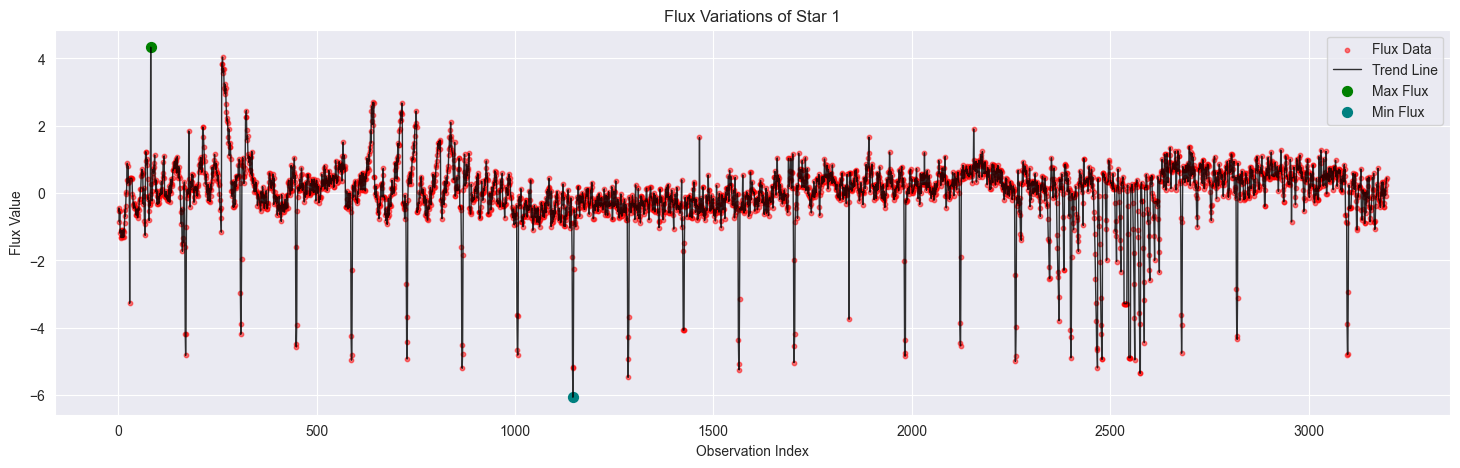


Star 1 - Max Flux: 4.333669297161058, Min Flux: -6.062920493278724, Label: 2.0

Star 1 Have Planets


-------------------------Star 2-------------------------



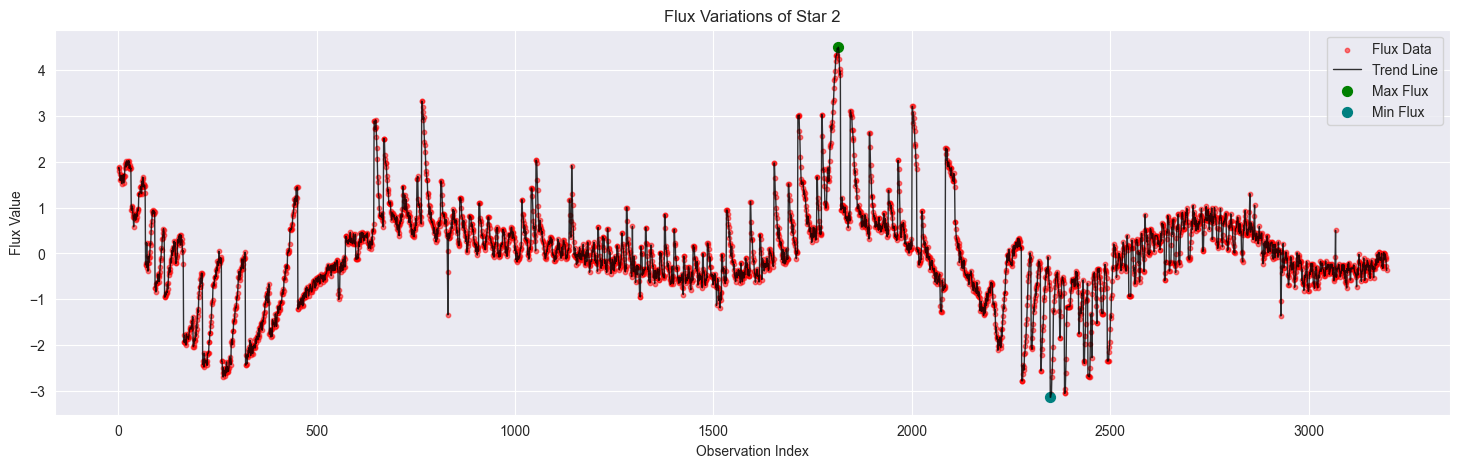


Star 2 - Max Flux: 4.492751198100301, Min Flux: -3.1330711686652046, Label: 2.0

Star 2 Have Planets


-------------------------Star 3-------------------------



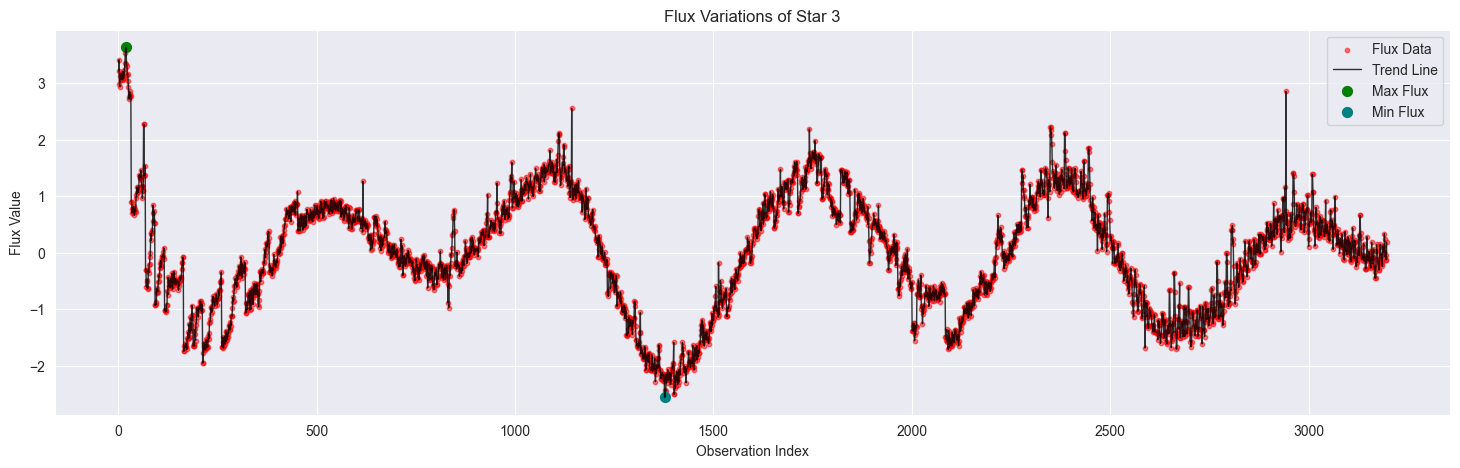


Star 3 - Max Flux: 3.6317437598257554, Min Flux: -2.5548883726286555, Label: 2.0

Star 3 Have Planets


-------------------------Star 5084-------------------------



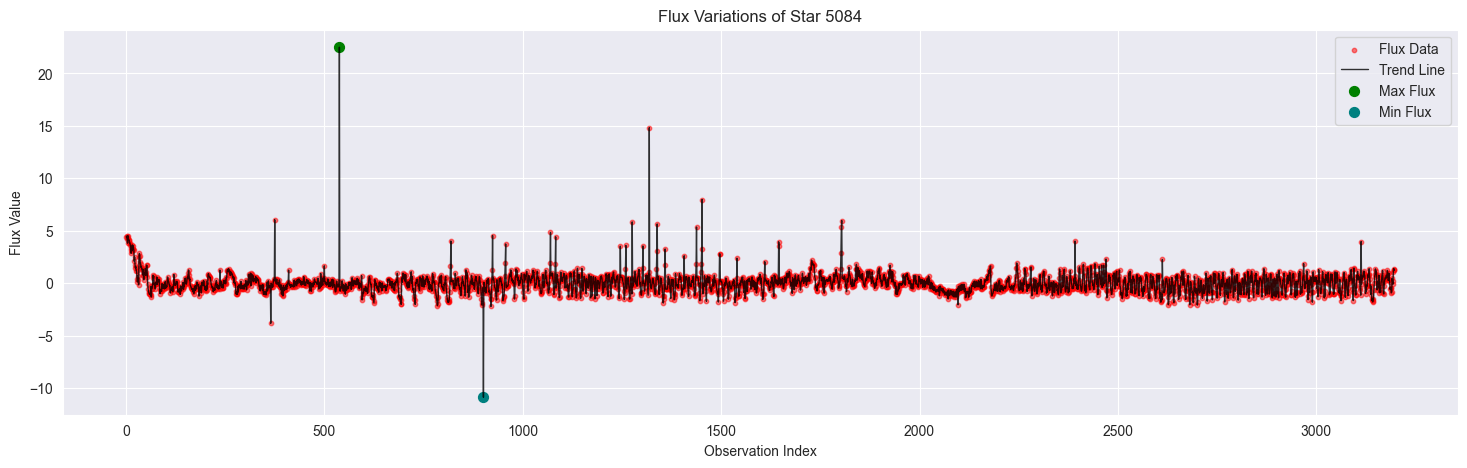


Star 5084 - Max Flux: 22.500192275836703, Min Flux: -10.8820962115776, Label: 1.0

Star 5084 Do not have Planets


-------------------------Star 5085-------------------------



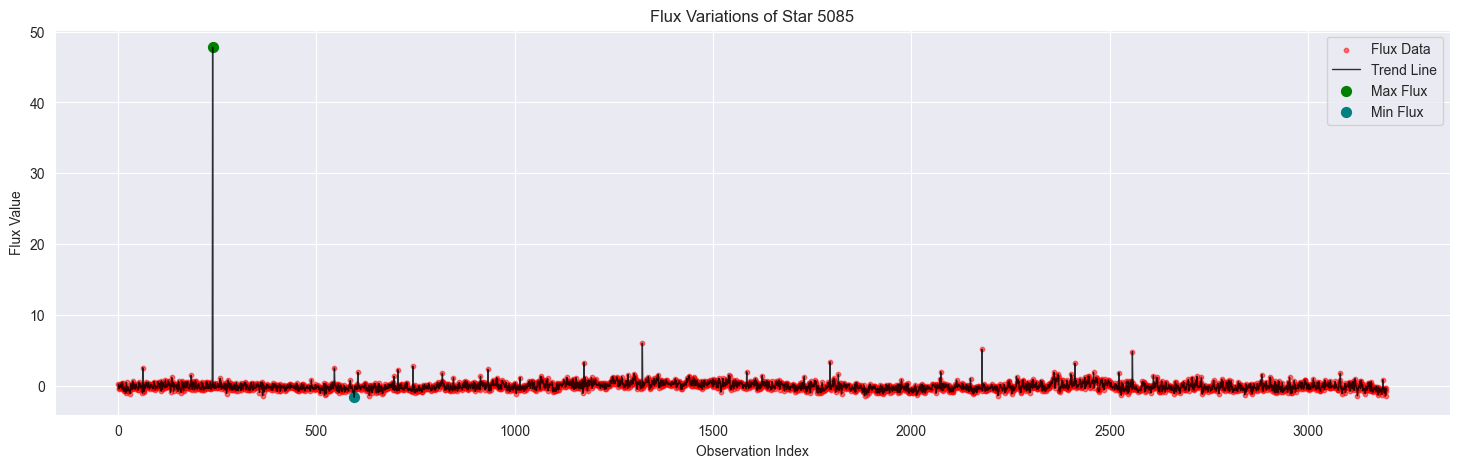


Star 5085 - Max Flux: 47.794010001292165, Min Flux: -1.5687286940371377, Label: 1.0

Star 5085 Do not have Planets


-------------------------Star 5086-------------------------



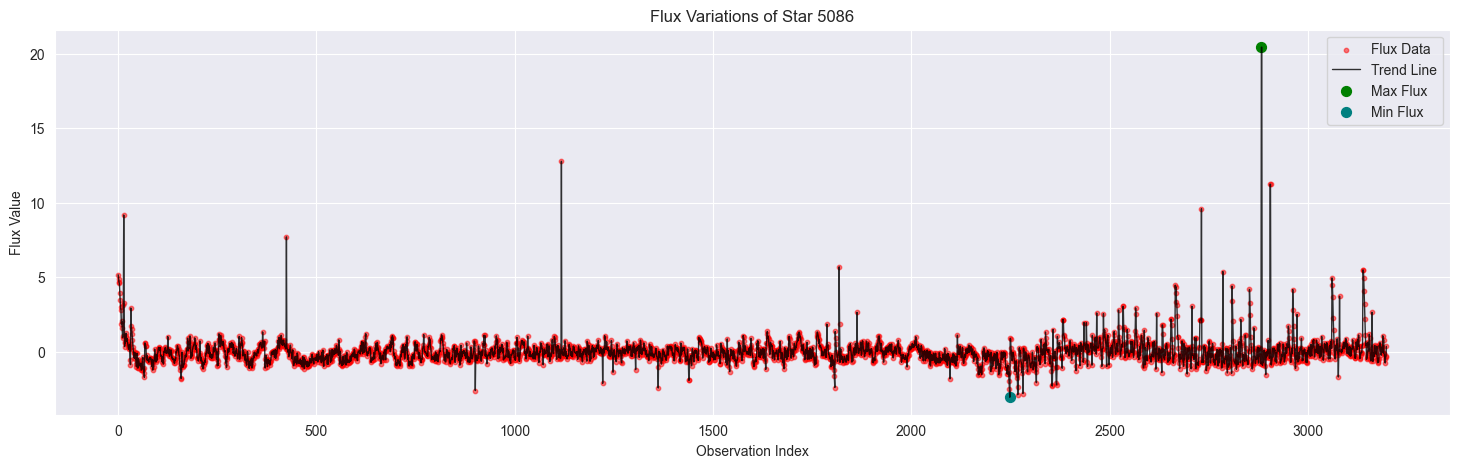


Star 5086 - Max Flux: 20.43128399011363, Min Flux: -3.050663121676425, Label: 1.0

Star 5086 Do not have Planets



In [141]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set Seaborn style for better visualization
sns.set_style("darkgrid")

# Define selected stars
stars = {
    "Star 1": nomz_train_df.iloc[1, :],
    "Star 2": nomz_train_df.iloc[2, :],
    "Star 3": nomz_train_df.iloc[3, :],
    "Star 5084": nomz_train_df.iloc[5084, :],
    "Star 5085": nomz_train_df.iloc[5085, :],
    "Star 5086": nomz_train_df.iloc[5086, :]
}

# Generate x-values
x_values = np.arange(1, len(stars["Star 1"]))

# Iterate through each star and generate individual plots
for star_name, flux_values in stars.items():
    y_values = flux_values[1:]
    max_flux = y_values.max()
    min_flux = y_values.min()
    acutal_label = flux_values.iloc[0]

    plt.figure(figsize=(18, 5), dpi=100)

    print(f"\n{"-"*25}{star_name}{"-"*25}\n")

    # Scatter plot and line plot overlay
    plt.scatter(x_values, y_values, alpha=0.5, label="Flux Data", color="red", s=10)
    plt.plot(x_values, y_values, color="black", linewidth=1, label="Trend Line",alpha = 0.8)

    # Highlight max and min points
    plt.scatter(x_values[y_values.argmax()], max_flux, color="green", marker="o", s=50, label="Max Flux")
    plt.scatter(x_values[y_values.argmin()], min_flux, color="teal", marker="o", s=50, label="Min Flux")

    # Labels and title
    plt.xlabel("Observation Index")
    plt.ylabel("Flux Value")
    plt.title(f"Flux Variations of {star_name}")
    plt.legend()

    # Show the plot for each star
    plt.show()

    # Print max and min values
    print(f"\n{star_name} - Max Flux: {max_flux}, Min Flux: {min_flux}, Label: {acutal_label}")
    print(f"\n{star_name} {"Have Planets" if acutal_label == 2 else "Do not have Planets"}\n")


As confirmed from the graph the mean normilization (it do not consider's outliers) is giving a smoother graph as compared to the z-score normilization (it consider's outliers)

We will use the *mean normalisation* method. Let's understand the *mean normalisation* method.

Consider a series of numbers having the values

$$x_1, x_2, x_3, ... , x_N$$

where $N$ is the total number of values in a series.

Let

- $x_{mean}$ denote the mean (or average) value of a series

- $x_{min}$ denote the minimum value in a series and

- $x_{max}$ denote the maximum value in a series

The normalised value in a series is calculated as

$$x_{norm} = \frac{x_p - x_{mean}}{x_{max} - x_{min}}$$

where

$$x_p = x_1, x_2, x_3, ..., x_N$$

So after normalisation, the new values in the series will be

$$\left(\frac{x_1 - x_{mean}}{x_{max} - x_{min}}\right), \left(\frac{x_2 - x_{mean}}{x_{max} - x_{min}}\right), \left(\frac{x_3 - x_{mean}}{x_{max} - x_{min}}\right), ..., \left(\frac{x_N - x_{mean}}{x_{max} - x_{min}}\right)$$

For e.g., consider the series $[5, 192, 20019, 12, 209]$.

- The average value of the series is $x_{mean} = 4087.4$

- The minimum value in the series is $x_{min} = 5$

- The maximum value in the series is $x_{max} = 20019$

So, after normalisation, the new series would have the following numbers.

$$\left[ \left( \frac{5 - 4087.4}{20019 - 5} \right), \left( \frac{192 - 4087.4}{20019 - 5} \right), \left( \frac{20019 - 4087.4}{20019 - 5} \right), \left( \frac{12 - 4087.4}{20019 - 5} \right), \left( \frac{209 - 4087.4}{20019 - 5} \right) \right]$$

$$\Rightarrow \left[-0.203977, -0.194634, 0.796023, -0.203627, -0.193784 \right]$$

or

$$\left[-\frac{203,977}{1,000,000}, -\frac{194,634}{1,000,000}, \frac{796,023}{1,000,000}, -\frac{203,627}{1,000,000}, -
\frac{193,784}{1,000,000} \right]$$

As you can see, after normalisation all the new values are on the same scale which is $\frac{1}{1,000,000}$ or $10^{-6}$.


---

In [142]:
nom_test_df = exo_test_df.iloc[:,1:].apply(norm, axis = 1)
nom_test_df[:5]

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,0.273347,0.228221,0.196676,0.110003,0.104130,0.088690,0.040926,0.014337,0.013534,-0.052079,...,0.031635,0.042578,0.031451,-0.005393,0.028904,0.102708,0.071576,0.080408,0.616438,0.130742
1,0.394038,0.391480,0.392680,0.390974,0.388955,0.386673,0.386340,0.382364,0.381035,0.374634,...,-0.047311,-0.075404,-0.092643,-0.118456,-0.134109,-0.150638,-0.164944,-0.171944,-0.166961,-0.148790
2,0.648150,0.627582,0.591444,0.519002,0.466046,0.385214,0.340496,0.281192,0.162553,0.119260,...,0.018179,-0.034769,-0.032201,-0.041117,-0.057967,-0.128412,-0.067972,-0.119374,-0.023437,0.027941
3,-0.232813,-0.233212,-0.238944,-0.235869,-0.208281,-0.220224,-0.222214,-0.208586,-0.197319,-0.188186,...,0.056186,0.047254,0.047254,0.039873,0.021893,0.025227,0.025075,-0.017912,-0.059585,-0.046740
4,-0.006994,0.003426,0.006382,0.007610,0.003316,-0.000167,0.010016,-0.009471,0.008195,0.016842,...,-0.006247,-0.016795,-0.001531,0.001095,-0.004439,-0.027127,-0.025421,-0.016852,-0.020089,0.002564


Now, you insert the `LABEL` column to the `norm_test_df` DataFrame with the corresponding `LABEL` values.

In [143]:
nom_test_df.insert(loc = 0, column = 'LABEL', value= exo_test_df['LABEL'])
nom_test_df[:5]

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,0.273347,0.228221,0.196676,0.110003,0.104130,0.088690,0.040926,0.014337,0.013534,...,0.031635,0.042578,0.031451,-0.005393,0.028904,0.102708,0.071576,0.080408,0.616438,0.130742
1,2,0.394038,0.391480,0.392680,0.390974,0.388955,0.386673,0.386340,0.382364,0.381035,...,-0.047311,-0.075404,-0.092643,-0.118456,-0.134109,-0.150638,-0.164944,-0.171944,-0.166961,-0.148790
2,2,0.648150,0.627582,0.591444,0.519002,0.466046,0.385214,0.340496,0.281192,0.162553,...,0.018179,-0.034769,-0.032201,-0.041117,-0.057967,-0.128412,-0.067972,-0.119374,-0.023437,0.027941
3,2,-0.232813,-0.233212,-0.238944,-0.235869,-0.208281,-0.220224,-0.222214,-0.208586,-0.197319,...,0.056186,0.047254,0.047254,0.039873,0.021893,0.025227,0.025075,-0.017912,-0.059585,-0.046740
4,2,-0.006994,0.003426,0.006382,0.007610,0.003316,-0.000167,0.010016,-0.009471,0.008195,...,-0.006247,-0.016795,-0.001531,0.001095,-0.004439,-0.027127,-0.025421,-0.016852,-0.020089,0.002564


In [144]:
exo_train_df.columns

Index(['LABEL', 'FLUX.1', 'FLUX.2', 'FLUX.3', 'FLUX.4', 'FLUX.5', 'FLUX.6',
       'FLUX.7', 'FLUX.8', 'FLUX.9',
       ...
       'FLUX.3188', 'FLUX.3189', 'FLUX.3190', 'FLUX.3191', 'FLUX.3192',
       'FLUX.3193', 'FLUX.3194', 'FLUX.3195', 'FLUX.3196', 'FLUX.3197'],
      dtype='object', length=3198)

---

In [145]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report,accuracy_score


In [146]:
xtrain = nom_train_df.iloc[:,1:]
ytrain = nom_train_df["LABEL"]
xtest = nom_test_df.iloc[:,1:]
ytest = nom_test_df["LABEL"]

In [147]:
rfclf = RandomForestClassifier(n_estimators=150,n_jobs=-1)

rfclf.fit(xtrain,ytrain)


RandomForestClassifier(n_estimators=150, n_jobs=-1)

In [148]:
rfclf.score(xtrain,ytrain)

1.0

In [149]:
ypred = rfclf.predict((xtest))
print(ypred)
print("___"*90)

accuracy = accuracy_score(ytest,ypred)
print(f"Model Accuracy: {accuracy*100:4f} %")

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

99.122807

In [150]:
confusion_matrix(ytest,ypred)

array([[565,   0],
       [  5,   0]])

In [151]:
exo_test_df.shape[0] * 100 / exo_train_df.shape[0]

11.205032435620208

In [152]:
import xgboost as xg

md = xg.XGBClassifier()
md.fit(xtrain,ytrain-1)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [159]:
y_pred = md.predict(xtest)
y_pred = pd.Series(y_pred) +1
print(y_pred.value_counts())

1    570
Name: count, dtype: int64


In [161]:
print(y_pred)

0      1
1      1
2      1
3      1
4      1
      ..
565    1
566    1
567    1
568    1
569    1
Length: 570, dtype: int64


In [162]:
confusion_matrix(ytest,y_pred)

array([[565,   0],
       [  5,   0]])

In [163]:
print(ytest.value_counts())

LABEL
1    565
2      5
Name: count, dtype: int64


In [164]:
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       565
           2       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



c:\Users\Asus\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Asus\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Asus\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

We are still getiting the same results Let's try something else

---